# Homework-2
## Fahrettin Ege Bilge
## 21070001052

## Task1: Bottleneck Residual Block in ResNet
### Design of Bottleneck Residual Block

A bottleneck residual block is a variant of the basic residual block used in ResNet architectures. It involves a sequence of layers that perform downsampling, convolution, and upsampling, followed by a residual connection. Below is the structure of a bottleneck block:

1x1 Convolution: Reduces the dimensionality (number of channels) for computational efficiency.
3x3 Convolution: Applies the main convolution operation.
1x1 Convolution: Restores the dimensionality back to the original.
Each convolutional layer is followed by Batch Normalization (BN) and ReLU activation. The residual connection adds the input to the output of these layers.


```
Input
  |
 [1x1 Conv] --> BN --> ReLU
  |  
 [3x3 Conv] --> BN --> ReLU
  |
 [1x1 Conv] --> BN
  |
 [Add] --> ReLU
  |
Output
```
### Structure:


#### 1.Convolutional Layer with 1x1 filters (Compression layer):

- The purpose of this layer is to reduce the dimensionality of the input feature maps, thus lowering the computational cost.
- Typically followed by a batch normalization layer and a rectified linear unit (ReLU) activation function.

#### 2.Convolutional Layer with 3x3 filters:
- This layer applies a standard convolution operation to the feature maps obtained from the compression layer.
- Followed by batch normalization and ReLU activation.

#### 3.Convolutional Layer with 1x1 filters (Expansion layer):
- This layer expands the dimensionality of the feature maps back to the original or desired dimensionality.
- Followed by batch normalization but **no** activation function.


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import time

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# Load and prepare the dataset
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
trn_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
vld_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
tst_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [15]:

# Split the training set into training and validation partitions
trn_size = int(0.8 * len(trn_dataset))
vld_size = len(trn_dataset) - trn_size
torch.manual_seed(0)
trn_dataset, vld_dataset = random_split(trn_dataset, [trn_size, vld_size])
classes = 'Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck'
num_classes = len(classes)
batch_size = 128
trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
vld_loader = DataLoader(vld_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
tst_loader = DataLoader(tst_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [16]:
# Define the bottleneck residual block
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if stride != 1 or in_channels != out_channels * 4:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [17]:
# Define the CNN model with bottleneck blocks
class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        layers = []
        layers.append(BottleneckBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * 4
        for _ in range(1, blocks):
            layers.append(BottleneckBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [27]:
# Initialize model, criterion, and optimizer
model = CustomResNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()

# SGD with momentum
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [28]:
import time

def evaluate_model(model, testloader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(testloader.dataset)
    return avg_loss, accuracy

# Training function
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=20):
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time of the epoch

        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = 100. * correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        val_epoch_loss, val_epoch_acc = evaluate_model(model, test_loader, criterion)
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        end_time = time.time()  # End time of the epoch
        epoch_duration = end_time - start_time  # Duration of the epoch

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}, Time: {epoch_duration:.2f}s')

    return train_loss, train_acc, val_loss, val_acc



In [29]:
# Train the model
train_loss, train_acc, val_loss, val_acc = train_model(model,criterion,optimizer,trn_loader,tst_loader,20)

Epoch [1/20], Train Loss: 1.8882, Train Acc: 31.5800, Val Loss: 1.9297, Val Acc: 40.8100, Time: 66.15s
Epoch [2/20], Train Loss: 1.3432, Train Acc: 51.1150, Val Loss: 1.3381, Val Acc: 55.4900, Time: 66.22s
Epoch [3/20], Train Loss: 1.0255, Train Acc: 63.2725, Val Loss: 2.2532, Val Acc: 60.5100, Time: 66.21s
Epoch [4/20], Train Loss: 0.8122, Train Acc: 71.4175, Val Loss: 1.0896, Val Acc: 66.1500, Time: 66.43s
Epoch [5/20], Train Loss: 0.6345, Train Acc: 77.5325, Val Loss: 1.0777, Val Acc: 71.1600, Time: 66.34s
Epoch [6/20], Train Loss: 0.5075, Train Acc: 82.2650, Val Loss: 0.8778, Val Acc: 71.5900, Time: 66.35s
Epoch [7/20], Train Loss: 0.3922, Train Acc: 86.1875, Val Loss: 0.8714, Val Acc: 75.5000, Time: 66.46s
Epoch [8/20], Train Loss: 0.3034, Train Acc: 89.3075, Val Loss: 0.9066, Val Acc: 75.8300, Time: 66.36s
Epoch [9/20], Train Loss: 0.2146, Train Acc: 92.3975, Val Loss: 0.8682, Val Acc: 76.3300, Time: 66.38s
Epoch [10/20], Train Loss: 0.1830, Train Acc: 93.5375, Val Loss: 0.8449, 

In [44]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Save Model State Dict
import torch
# Assuming model is your trained PyTorch model
torch.save(model.state_dict(), '/content/drive/My Drive/std_model.pth')

# Load Model State Dict
# Assuming CustomResNet is the model class and num_classes is the same as before
#model = CustomResNet(num_classes=10).to(device)
#model.load_state_dict(torch.load('/content/drive/My Drive/my_model.pth'))
#model.eval()  # Set the model to evaluation mode


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


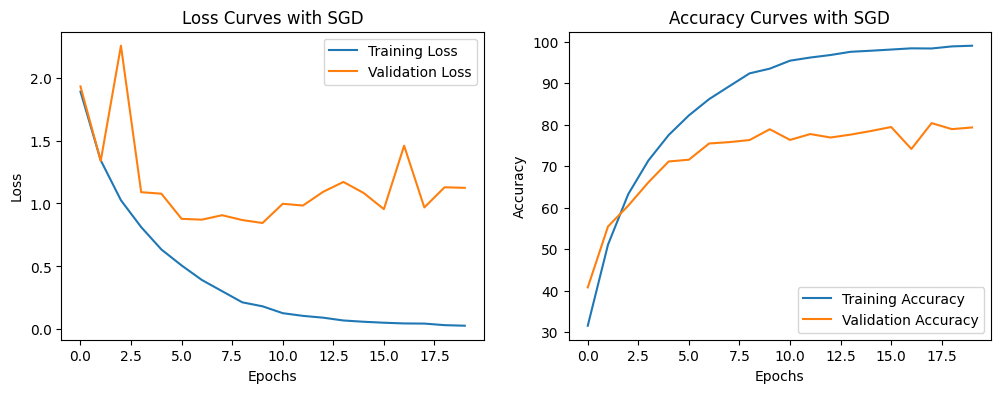

In [60]:
# Plot the learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves with SGD')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves with SGD')

plt.show()

### Training Summary

The model appears to have learned from the training data as the training loss 0.0288 decreased and training accuracy 99.0600 increased over epochs.

However, there are signs of overfitting. While the validation loss 0.9686 also decreased, it did not decrease as significantly as the training loss. This suggests the model may be learning patterns specific to the training data that don't generalize well to unseen data.

I should onsider using techniques to mitigate overfitting, such as early stopping.

**Best parameters for this training was:**
- lr=0.01
- momentum=0.9
- weight_decay=1e-4


In [36]:
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo

[INFO] Couldn't find torchinfo... installing it.


In [38]:
from torchinfo import summary
model_stats = summary(model)
print(model_stats)

Layer (type:depth-idx)                   Param #
CustomResNet                             --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BottleneckBlock: 2-1              --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─BottleneckBlock: 2-2              --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

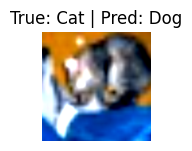

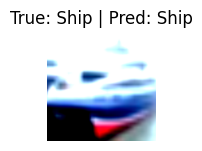

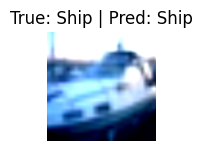

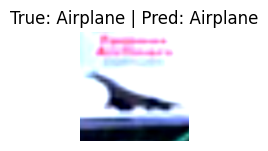

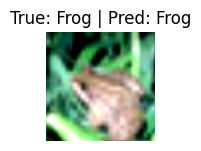

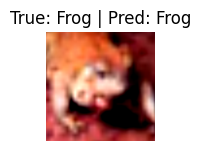

In [35]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    # Clip the data to be between 0 and 1
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def visualize_model_predictions(model, loader, num_images=6, classes=None):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'True: {classes[labels[j].item()]} | Pred: {classes[preds[j].item()]}')
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
    model.train(mode=was_training)

visualize_model_predictions(model, loader=tst_loader, classes=classes)

## Task2: Different Training Dynamics


### (a)Using ADAM optimizer with weight decay
I will modify the optimizer to use ADAM with weight decay and compare the performance.

In [41]:
# Using ADAM optimizer with weight decay
AdamModel = CustomResNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
AdamOptimizer = optim.Adam(AdamModel.parameters(), lr=0.01, weight_decay=1e-4)
adam_train_loss, adam_train_acc, adam_val_loss, adam_val_acc = train_model(AdamModel,criterion,AdamOptimizer,trn_loader,tst_loader,20)

Epoch [1/20], Train Loss: 2.0896, Train Acc: 25.2425, Val Loss: 2.0030, Val Acc: 22.3600, Time: 66.83s
Epoch [2/20], Train Loss: 1.6330, Train Acc: 38.3550, Val Loss: 1.7551, Val Acc: 34.1100, Time: 66.55s
Epoch [3/20], Train Loss: 1.3816, Train Acc: 49.3800, Val Loss: 1.5931, Val Acc: 41.8200, Time: 66.70s
Epoch [4/20], Train Loss: 1.1992, Train Acc: 56.7650, Val Loss: 1.3544, Val Acc: 52.0300, Time: 66.73s
Epoch [5/20], Train Loss: 1.0839, Train Acc: 61.2900, Val Loss: 1.0765, Val Acc: 61.8200, Time: 66.67s
Epoch [6/20], Train Loss: 1.0142, Train Acc: 63.6700, Val Loss: 1.2664, Val Acc: 55.0300, Time: 66.60s
Epoch [7/20], Train Loss: 0.9648, Train Acc: 65.5625, Val Loss: 1.3130, Val Acc: 57.5000, Time: 66.64s
Epoch [8/20], Train Loss: 0.9271, Train Acc: 66.8850, Val Loss: 1.0579, Val Acc: 62.9600, Time: 66.64s
Epoch [9/20], Train Loss: 0.8945, Train Acc: 68.0900, Val Loss: 0.9865, Val Acc: 65.4900, Time: 66.81s
Epoch [10/20], Train Loss: 0.8635, Train Acc: 69.6200, Val Loss: 0.9367, 

In [42]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Save Model State Dict
import torch
# Assuming model is your trained PyTorch model
torch.save(AdamModel.state_dict(), '/content/drive/My Drive/adam_model.pth')

# Load Model State Dict
# Assuming CustomResNet is the model class and num_classes is the same as before
#model = CustomResNet(num_classes=10).to(device)
#model.load_state_dict(torch.load('/content/drive/My Drive/my_model.pth'))
#model.eval()  # Set the model to evaluation mode


Mounted at /content/drive


In [59]:
adam_model_stats = summary(AdamModel)
print(adam_model_stats)

Layer (type:depth-idx)                   Param #
CustomResNet                             --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BottleneckBlock: 2-1              --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─BottleneckBlock: 2-2              --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

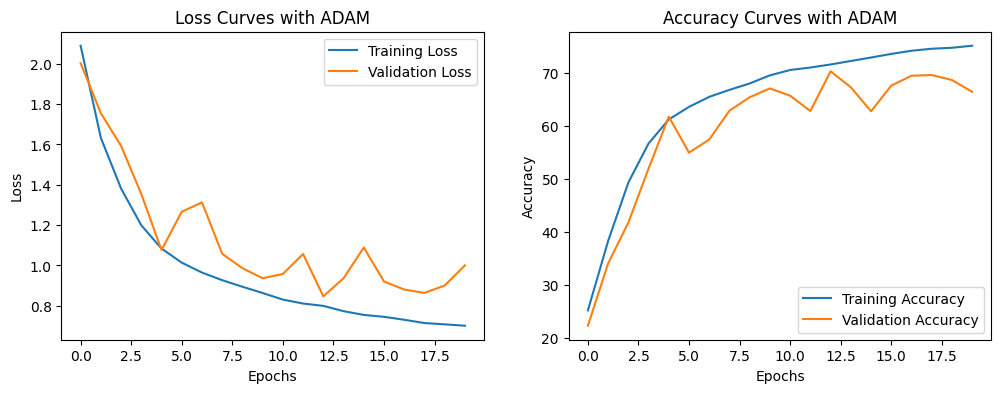

In [61]:
# Plot the learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(adam_train_loss, label='Training Loss')
plt.plot(adam_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves with ADAM')

plt.subplot(1, 2, 2)
plt.plot(adam_train_acc, label='Training Accuracy')
plt.plot(adam_val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves with ADAM')

plt.show()

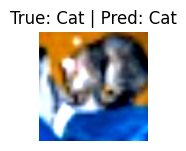

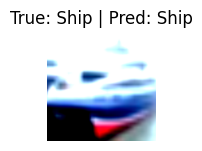

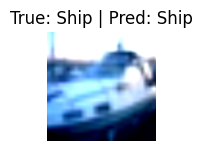

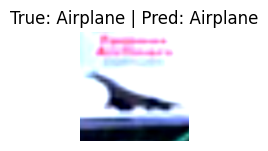

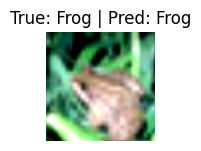

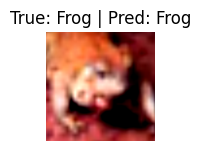

In [48]:
visualize_model_predictions(AdamModel, loader=tst_loader, classes=classes)

The Adam optimizer likely performed better due to its ability to mitigate overfitting during training.

### (b) Learning Rate Scheduling with ReduceLROnPlateau
 I will add a learning rate scheduler to dynamically adjust the learning rate based on validation performance.

In [50]:
# Learning rate scheduling with ReduceLROnPlateau
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the scheduler
scheduler = ReduceLROnPlateau(AdamOptimizer, mode='max', factor=0.1, patience=2)

# Train the model with scheduler
def train_model_with_scheduler(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs=20):
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time of the epoch

        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = 100. * correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        val_epoch_loss, val_epoch_acc = evaluate_model(model, test_loader, criterion)
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        scheduler.step(val_epoch_acc)  # Step the scheduler based on validation accuracy

        end_time = time.time()  # End time of the epoch
        epoch_duration = end_time - start_time  # Duration of the epoch

        # Get the current learning rate
        current_lr = optimizer.param_groups[0]["lr"]

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}, Time: {epoch_duration:.2f}s, LR: {current_lr:.6f}')

    return train_loss, train_acc, val_loss, val_acc

# Train the model with scheduler
adam_train_loss_sched, adam_train_acc_sched, adam_val_loss_sched, adam_val_acc_sched = train_model_with_scheduler(AdamModel, criterion, AdamOptimizer, scheduler, trn_loader, tst_loader, 20)


Epoch [1/20], Train Loss: 0.6830, Train Acc: 75.8125, Val Loss: 0.9713, Val Acc: 66.7700, Time: 66.51s, LR: 0.010000
Epoch [2/20], Train Loss: 0.6694, Train Acc: 76.2925, Val Loss: 0.8880, Val Acc: 68.7700, Time: 66.44s, LR: 0.010000
Epoch [3/20], Train Loss: 0.6607, Train Acc: 76.6350, Val Loss: 1.0998, Val Acc: 63.5800, Time: 66.58s, LR: 0.010000
Epoch [4/20], Train Loss: 0.6477, Train Acc: 77.0900, Val Loss: 0.8753, Val Acc: 70.4300, Time: 66.54s, LR: 0.010000
Epoch [5/20], Train Loss: 0.6364, Train Acc: 77.7900, Val Loss: 0.8321, Val Acc: 70.9700, Time: 66.51s, LR: 0.010000
Epoch [6/20], Train Loss: 0.6281, Train Acc: 77.9850, Val Loss: 0.7908, Val Acc: 72.3600, Time: 66.44s, LR: 0.010000
Epoch [7/20], Train Loss: 0.6231, Train Acc: 78.0400, Val Loss: 0.8611, Val Acc: 70.5600, Time: 66.52s, LR: 0.010000
Epoch [8/20], Train Loss: 0.6087, Train Acc: 78.3225, Val Loss: 0.8819, Val Acc: 69.7600, Time: 66.51s, LR: 0.010000
Epoch [9/20], Train Loss: 0.5991, Train Acc: 78.9400, Val Loss: 

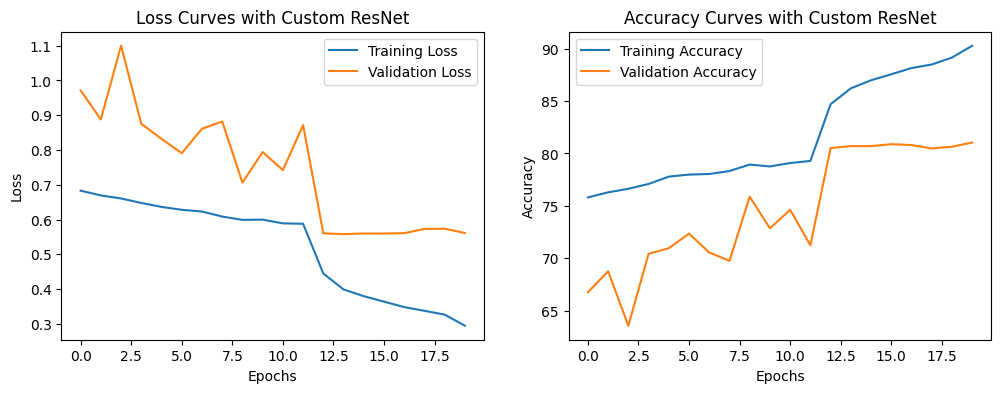

In [51]:
# Plot the learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(adam_train_loss_sched, label='Training Loss')
plt.plot(adam_val_loss_sched, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves with Custom ResNet')

plt.subplot(1, 2, 2)
plt.plot(adam_train_acc_sched, label='Training Accuracy')
plt.plot(adam_val_acc_sched, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves with Custom ResNet')

plt.show()

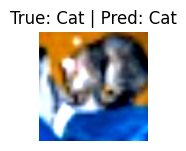

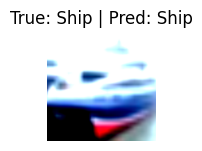

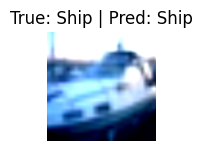

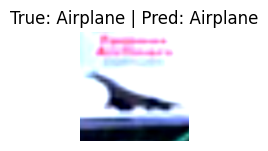

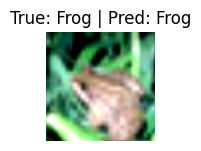

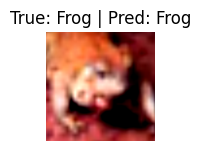

In [52]:
visualize_model_predictions(AdamModel, loader=tst_loader, classes=classes)

## Task 3: Transfer Learning with ResNet-50
I will use a pre-trained ResNet-50 model and fine-tune its last layer for CIFAR-10 classification.

In [56]:
# Load pre-trained ResNet-50 model
pre_model = models.resnet50(pretrained=True)

# Freeze all the layers
for param in pre_model.parameters():
    param.requires_grad = False

# Modify and train only the last layer
num_ftrs = model.fc.in_features
pre_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 10)
)

# Transfer model to GPU if available
pre_model = pre_model.to(device)

# Define optimizer and criterion
optimizer = optim.Adam(pre_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()



In [57]:
# Train the model
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = 100. * correct / total

        # Validate the model
        val_loss, val_acc = evaluate_model(model, criterion, val_loader)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

def evaluate_model(model, criterion, data_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100. * correct / total

    return avg_loss, accuracy


In [58]:
# Train the model
train_model(pre_model, criterion, optimizer, trn_loader, vld_loader, num_epochs=10)

# Evaluate on the test set
test_loss, test_acc = evaluate_model(pre_model, criterion, tst_loader)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')


Epoch [1/10], Train Loss: 0.9070, Train Acc: 68.60%, Val Loss: 0.7140, Val Acc: 75.84%
Epoch [2/10], Train Loss: 0.7274, Train Acc: 75.08%, Val Loss: 0.6602, Val Acc: 76.86%
Epoch [3/10], Train Loss: 0.7043, Train Acc: 75.62%, Val Loss: 0.6498, Val Acc: 77.56%
Epoch [4/10], Train Loss: 0.6776, Train Acc: 76.68%, Val Loss: 0.6125, Val Acc: 78.62%
Epoch [5/10], Train Loss: 0.6575, Train Acc: 77.20%, Val Loss: 0.6226, Val Acc: 78.30%
Epoch [6/10], Train Loss: 0.6499, Train Acc: 77.48%, Val Loss: 0.6185, Val Acc: 78.30%
Epoch [7/10], Train Loss: 0.6330, Train Acc: 77.97%, Val Loss: 0.6055, Val Acc: 78.57%
Epoch [8/10], Train Loss: 0.6330, Train Acc: 77.86%, Val Loss: 0.5922, Val Acc: 79.52%
Epoch [9/10], Train Loss: 0.6153, Train Acc: 78.58%, Val Loss: 0.5921, Val Acc: 79.34%
Epoch [10/10], Train Loss: 0.6073, Train Acc: 78.77%, Val Loss: 0.6250, Val Acc: 78.23%
Test Loss: 0.6247, Test Acc: 78.49%


## Conclusion
In this homework, I implemented and trained a ResNet model with bottleneck residual blocks from scratch, experimented with different training dynamics using ADAM and learning rate scheduling, and applied transfer learning using a pre-trained ResNet-50 model. Each method was evaluated on the CIFAR-10 dataset. I aimed to achieve high test accuracy while ensuring robust training processes.

# References
- Shi, Dachuan & Ye 叶运广, Yunguang & Gillwald, Marco & Hecht, Markus. (2020). Designing a lightweight 1D convolutional neural network with Bayesian optimization for wheel flat detection using carbody accelerations. 10.1080/23248378.2020.1795942.

- http://karpathy.github.io/2019/04/25/recipe/

- https://github.com/TylerYep/torchinfo

- https://colab.research.google.com/github/Mostafa-MR/Convert_ipynb_to_HTML_in_Colab/blob/main/Convert_ipynb_to_HTML_in_Colab.ipynb#scrollTo=4FhcP565-JpA